In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import epmwebapi as epm
import datetime

import getpass
user = input('EPM user:')
password = getpass.getpass("EPM password:")

EPM user:sa
EPM password:········


In [3]:
%%time
#crie o objeto de conexão informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
connection = epm.EpmConnection('http://localhost:44333', 'http://localhost:44332', user, password)

#nomes das basic variables
wind = 'SP01_WindSpeedAvg'
power = 'SP01_PowerAvg'
direction = 'SP01_WindDirection'

#intervalo da consulta
initime = datetime.datetime(2014, 3, 1, 0, 0, 0, 0)
endtime = initime + datetime.timedelta(days=5)

#busca o objeto no EPM Server
bv_wind = connection.getDataObjects([wind])
bv_power = connection.getDataObjects([power])
bv_direction = connection.getDataObjects([direction])

#confugura a consulta
queryperiod = epm.QueryPeriod(initime, endtime)
processInterval = datetime.timedelta(seconds=600)
aggregationdetails = epm.AggregateDetails(processInterval, epm.AggregateType.Interpolative)

#realiza a consulta
wind_data = bv_wind[wind].historyReadAggregate(aggregationdetails, queryperiod)
power_data = bv_power[power].historyReadAggregate(aggregationdetails, queryperiod)
direction_data = bv_direction[direction].historyReadAggregate(aggregationdetails, queryperiod)

Wall time: 8.09 s


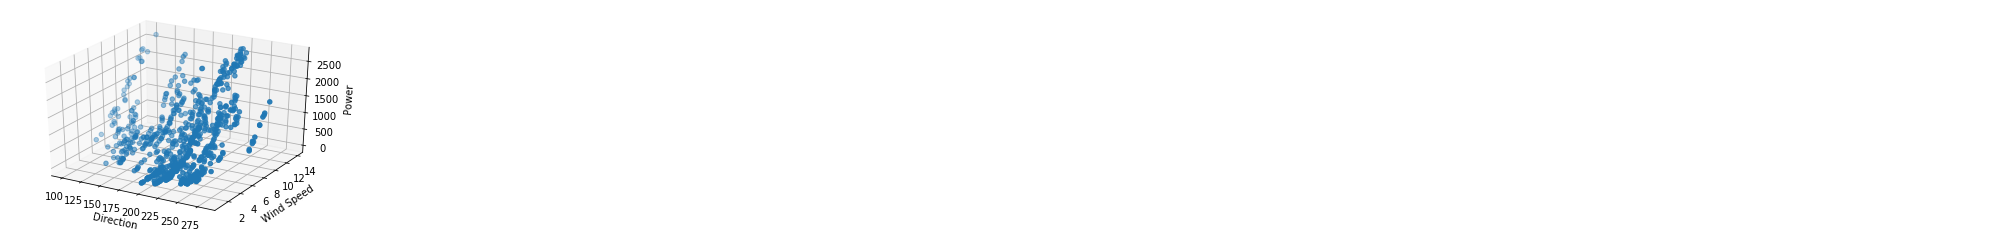

In [4]:
%matplotlib inline
x, y, z = direction_data['Value'], wind_data['Value'], power_data['Value']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('Direction')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('Power')
plt.show()


**Gerando espirais para visualização de linha do tempo**

Esse é um método que permite visualizar um longo periodo de tempo, permitindo acompanhar uma evolução dos valores, sem foco na precisão.

In [5]:
# Buscando, limpando e formatando dados

#variável para consulta
temperature = 'ADM_Temperature'

#intervalo da consulta
initime = datetime.datetime(2014, 1, 1, 0, 0, 0, 0)
endtime = datetime.datetime(2014, 12, 31, 23, 59, 59, 0)

#busca o objeto no EPM Server
tag_temperature = connection.getDataObjects(temperature)

#confugura a consulta para agregar um valor medio a cada 30 dias
queryperiod = epm.QueryPeriod(initime, endtime)
processInterval = datetime.timedelta(days=29)
aggregationdetails = epm.AggregateDetails(processInterval, epm.AggregateType.Average)

#realiza a consulta
data = tag_temperature[temperature].historyReadAggregate(aggregationdetails, queryperiod)
print(len(data))

13


In [6]:
#converte para pandas para facilitar a manipulação de dados
import pandas as pd

df1 = pd.DataFrame(
        {'Value': data['Value'].tolist(),
         'Timestamp': data['Timestamp'].tolist()}
)

#mostra os primeiros 5 valores para verificarmos como ficaram os dados.
df1

,Value,Timestamp
0,25.741468,2014-01-01 00:00:00+00:00
1,26.150822,2014-01-30 00:00:00+00:00
2,25.399597,2014-02-28 00:00:00+00:00
3,25.593950,2014-03-29 00:00:00+00:00
4,23.525351,2014-04-27 00:00:00+00:00
5,22.105984,2014-05-26 00:00:00+00:00
6,23.345547,2014-06-24 00:00:00+00:00
7,22.810987,2014-07-23 00:00:00+00:00
8,24.005733,2014-08-21 00:00:00+00:00
9,23.887587,2014-09-19 00:00:00+00:00


In [7]:
df1['year'] = pd.DatetimeIndex(df1['Timestamp']).year
df1['month'] = pd.DatetimeIndex(df1['Timestamp']).month


df1.drop_duplicates(subset=['month'], keep='first', inplace=True)
df1

,Value,Timestamp,year,month
0,25.741468,2014-01-01 00:00:00+00:00,2014,1
2,25.399597,2014-02-28 00:00:00+00:00,2014,2
3,25.593950,2014-03-29 00:00:00+00:00,2014,3
4,23.525351,2014-04-27 00:00:00+00:00,2014,4
5,22.105984,2014-05-26 00:00:00+00:00,2014,5
6,23.345547,2014-06-24 00:00:00+00:00,2014,6
7,22.810987,2014-07-23 00:00:00+00:00,2014,7
8,24.005733,2014-08-21 00:00:00+00:00,2014,8
9,23.887587,2014-09-19 00:00:00+00:00,2014,9
10,25.288225,2014-10-18 00:00:00+00:00,2014,10


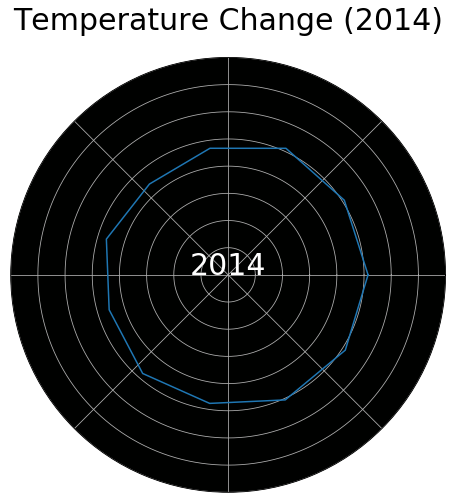

In [14]:
#Gerando uma visualização polar

fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')

ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])

#fig.set_facecolor("#003000")
ax1.set_facecolor('#000100')

ax1.set_title("Temperature Change (2014)", color='black', fontdict={'fontsize': 30})

ax1.text(0,0,"2014", color='black', size=30, ha='center')
theta = np.linspace(0, 2*np.pi, 12)
ax1.set_ylim(0, 40)


years = df1['year'].unique()

for year in years:    
    r = df1[df1['year'] == year]['Value']   
    
    ax1.text(0,0, str(year), color='white', size=30, ha='center')
    ax1.plot(theta, r)


In [ ]:
#fechando a conexão
connection.close()